In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from scipy.spatial.distance import cdist

import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score
set_config(display="diagram")

In [2]:
data = pd.read_csv("../data/final_data.csv", index_col=0)
data.head(5)

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD


# Creating Pipeline for Recommendation System 

In [25]:
data_for_recommendation = data.drop(["img_url", "laptop_name"], axis=1)
data_for_recommendation.head()

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC
1,Lenovo,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD
2,Huawei,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD
3,Dell,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD
4,Asus,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD


In [26]:
list(enumerate(data_for_recommendation.columns))

[(0, 'brand'),
 (1, 'display_size'),
 (2, 'processor_type'),
 (3, 'graphics_card'),
 (4, 'disk_space'),
 (5, 'discount_price'),
 (6, 'ratings_5max'),
 (7, 'disk_type')]

In [27]:
pipeline = Pipeline([
    ("tnf1", ColumnTransformer([
        ("one_hot_encoding", OneHotEncoder(dtype="int", sparse_output=False, handle_unknown="ignore"), [0,7]),
        ("scaling", StandardScaler(), [1, 5, 6]),
        ("ordinal_encoding", OrdinalEncoder(), [2, 3, 4])
    ], remainder="passthrough"))
])

pipeline.fit(data_for_recommendation.values)

Pipeline(steps=[('tnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 7]),
                                                 ('scaling', StandardScaler(),
                                                  [1, 5, 6]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  [2, 3, 4])]))])

In [28]:
x = pipeline.transform([["HP", 14.0, "Intel Celeron N4000", "NVIDIA GeForce MX150 (2 GB)", 64.0, 2344.0, 2.5, "SSD"]])[0]
x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        , -0.51443978, -0.6419836 ,
        0.52480414,  4.        , 44.        ,  3.        ])

In [29]:
data_for_recommendation = pipeline.transform(data_for_recommendation.values)
data_for_recommendation.shape

(203, 19)

Finding the optimal number of clusters using the silhoutter scores.

In [30]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(data_for_recommendation)
    kmeanModel.fit(data_for_recommendation)
  
    distortion = sum(np.min(cdist(data_for_recommendation, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / data_for_recommendation.shape[0]
    distortions.append(distortion)
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = distortion
    mapping2[k] = kmeanModel.inertia_

pd.DataFrame([pd.Series(mapping1, name="Distortions"), pd.Series(mapping2, name="Inertias")]).T

,Distortions,Inertias
1,14.286775,51225.059113
2,8.858401,19210.282484
3,6.572700,10338.340195
4,5.729373,7482.747795
5,5.371919,6535.237265
...,...,...
95,0.729005,168.243320
96,0.706962,164.476024
97,0.700066,160.933668
98,0.689018,159.978290


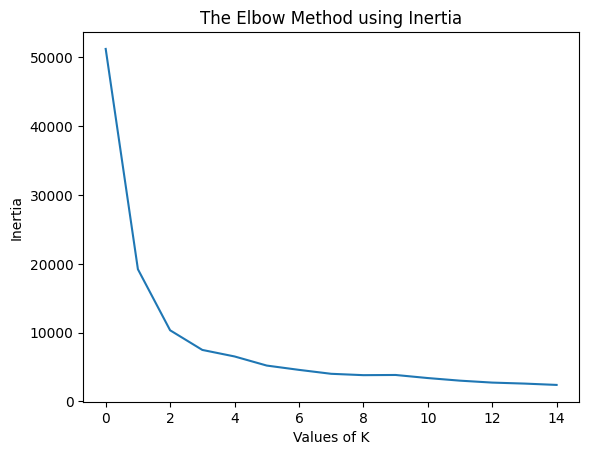

In [31]:
sns.lineplot(inertias[:15])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [32]:
# silhouette_scores = []
# for n_clusters in range(2, 9):
#     kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
#     cluster_labels = kmeans.fit_predict(data_for_recommendation)
#     silhouette_scores.append(silhouette_score(data_for_recommendation, cluster_labels))

# optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
# print(f"The optimal number of clusters is {optimal_n_clusters}")

## Adding KMeans model to the pipeline

In [33]:
model = KMeans(n_clusters=3, n_init="auto")
model.fit(data_for_recommendation)
pipeline.steps.append(("estimator", model))
pipeline

Pipeline(steps=[('tnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 7]),
                                                 ('scaling', StandardScaler(),
                                                  [1, 5, 6]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  [2, 3, 4])])),
                ('estimator', KMeans(n_clusters=3, n_init='auto'))])

In [34]:
data_for_recommendation = data.drop(["img_url", "laptop_name"], axis=1)
data["cluster"] = pipeline.predict(data_for_recommendation.values)
data.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,cluster
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD,0
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD,2
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD,0
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD,0


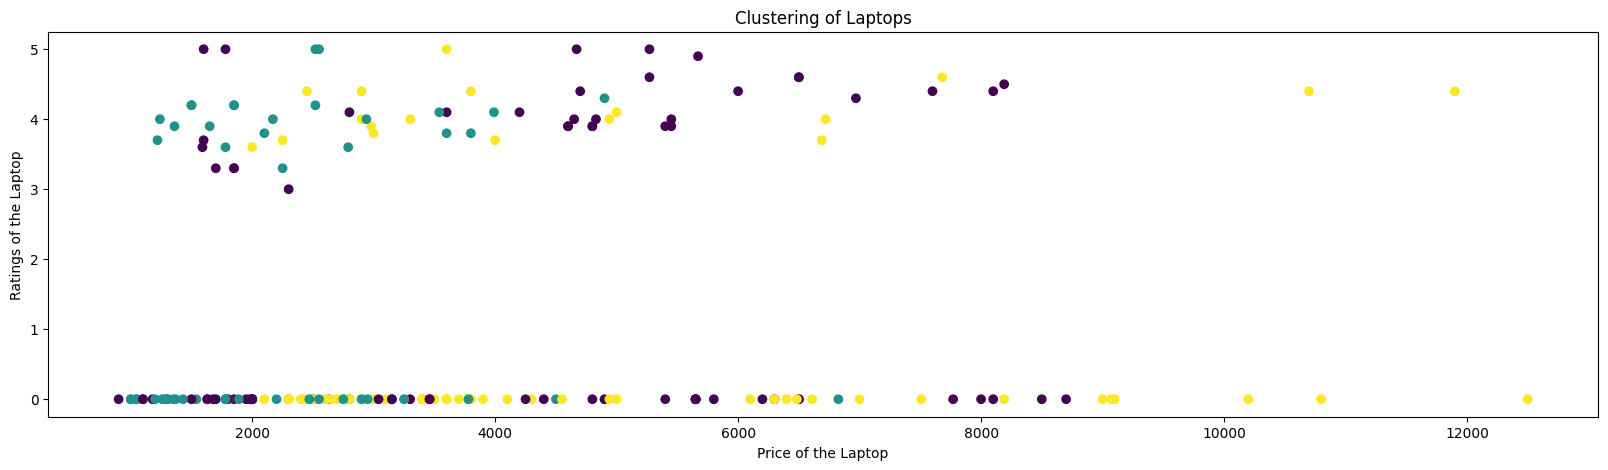

In [35]:
plt.figure(figsize=(20,5))
plt.scatter(x=data['discount_price'],y=data['ratings_5max'],c=data['cluster'])
plt.xlabel("Price of the Laptop")
plt.ylabel("Ratings of the Laptop")
plt.title("Clustering of Laptops")
plt.show()

### Recommending the laptop based on user preferences.
For example : if user prefers's a laptop with a 14 inch screen size, an above 3-star rating and disk space of atleast 32GB.

Creating a user preference dataframe.

In [36]:
user_pref = pd.DataFrame({
    "brand": ["HP"],
    "display_size": [15.6],
    "processor_type": ["Intel Celeron N4000"],
    "graphics_card": ["Intel HD Graphics 600"],
    "disk_space": [1024.0],
    "discount_price": [2000.0],
    "ratings_5max": [4.0],
    "disk_type": ["eMMC"]
})

user_pref

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,15.6,Intel Celeron N4000,Intel HD Graphics 600,1024.0,2000.0,4.0,eMMC


### Predicting the cluster the user's preferences belongs to

In [37]:
cluster = pipeline.predict(user_pref.values)[0]
cluster

1

### Recommending the laptops based on user's preference.

In [38]:
recommended_laptops = data[data['cluster'] == cluster]
recommended_laptops.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,cluster
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1
5,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Vostro 5471,14.0,Intel Core i7-8550U,AMD Radeon 530 (4 GB),128.0,3799.0,3.8,HDD,1
9,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,14-cf0007nx,14.0,Intel Core i5-8250U,AMD Radeon 530 (2 GB),16.0,2629.0,0.0,HDD,1
10,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,15-db0001nx,15.6,AMD A9-9425,AMD Radeon R5,1024.0,1999.0,0.0,HDD,1
11,Acer,https://encrypted-tbn0.gstatic.com/images?q=tb...,Swift 5,14.0,Intel Core i7-8565U,Intel GMA HD,512.0,4499.0,0.0,SSD,1


# Making the Recommender Class

In [7]:
data.drop(["img_url", "laptop_name"], axis=1).head()

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC
1,Lenovo,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD
2,Huawei,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD
3,Dell,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD
4,Asus,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD


In [13]:
class Recommender(Pipeline):
  def __init__(self, data, ignore_cols, steps):
    self.data = data               # copy of the entire data
    self.ignore_cols = ignore_cols # columns to ignore during fit process
    super().__init__(steps)        # creating pipeline

    # fit after dropping the ignore_cols
  def fit(self, X=None, y=None, **fit_params):
    data_fr = self.drop_cols().values
    return super().fit(data_fr)
  
    # return data after dropping ignore_cols
  def drop_cols(self):
    cols = self.ignore_cols.copy()
    return self.data.drop(cols, axis=1)

    # Predict clusters and add it as "clusters" column in the data
    # return the new data
  def make_clusters(self):
    self.data["clusters"] = self.predict(self.drop_cols().values)
    return self.data
  
    # get the cluster a user's data belongs to
  def get_cluster(self, user_pref):
    return super().predict(user_pref.values)[0]
  
    # get 'k' recommendations based on user's data
  def get_k_recommendations(self, user_pref, k=5):
    cluster = self.get_cluster(user_pref)
    return self.data[self.data["clusters"] == cluster].head(k)

# dummy data
user_pref = pd.DataFrame({
    "brand": ["HP"],
    "display_size": [15.6],
    "processor_type": ["Intel Celeron N4000"],
    "graphics_card": ["Intel HD Graphics 600"],
    "disk_space": [1024.0],
    "discount_price": [2000.0],
    "ratings_5max": [4.0],
    "disk_type": ["eMMC"]
})

preprocessor = ColumnTransformer([    
    ("one_hot_encoding", OneHotEncoder(dtype="int", sparse_output=False, handle_unknown="ignore"), [0,2,3,7]),
    ("scaling", StandardScaler(), [1, 5, 6]),
    ("ordinal_encoding", OrdinalEncoder(), [4])
], remainder="passthrough")

model = KMeans(n_clusters=3, n_init="auto")
recommender = Recommender(data.copy(), ["img_url", "laptop_name"], [
    ("preprocessing", preprocessor),
    ("model", model)
])

recommender.fit()
recommender.make_clusters().head()
recommender.get_k_recommendations(user_pref)

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,clusters
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD,2
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD,2
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD,2
10,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,15-db0001nx,15.6,AMD A9-9425,AMD Radeon R5,1024.0,1999.0,0.0,HDD,2
33,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,X543UB,15.6,Intel Core i7-8550U,NVIDIA GeForce MX110 (2 GB),1024.0,2499.0,0.0,HDD,2


# Saving the Recommender model

In [21]:
joblib.dump(recommender, "../api/models/model.obj")

['../api/models/model.obj']